In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools
import matplotlib.patches as mpatches

# 0. Load loaction and grouppings information

In [2]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type']]
INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch'}, inplace=True)

## 1. What fraction of CDS is also GERP high score bases?

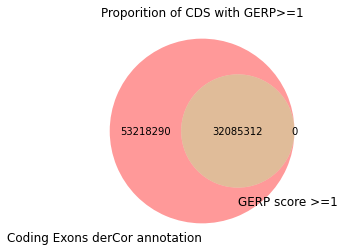

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Sizes for each group and their overlap
size_A = 85303602-32085312
size_B = 0
overlap_AB = 32085312

# Create a Venn diagram
venn_diagram = venn2(subsets=(size_A, size_B, overlap_AB), 
                     set_labels=('Coding Exons derCor annotation', 'GERP score >=1'))

# Display the Venn diagram
plt.title("Proporition of CDS with GERP>=1")
plt.show()

## 2. GERP and snpEff overlap. Sanity check

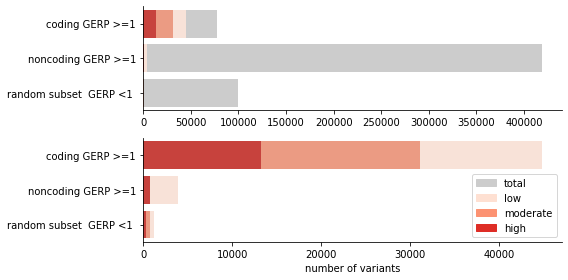

In [6]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/GERP/'
file_name = 'gerp_vs_snpeff.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## calculate fractions
df['high_f'] = df['high'] / df['total']
df['total_f'] = df['total'] / df['total']

df['h+m'] = df['high'] + df['moderate']
df['h+m+l'] = df['h+m'] + df['low']
df['h+m_f'] = df['h+m'] / df['total']
df['h+m+l_f'] = df['h+m+l'] / df['total']

p = ['#cccccc', '#fee0d2', '#fc9272', '#de2d26']
fig, axes = plt.subplots(2, 1, figsize = (8, 4))
ax1, ax2 = axes[0], axes[1]

## Plot total numbers
values_total = ['total', 'h+m+l', 'h+m', 'high']
values_fraction = ['h+m+l', 'h+m', 'high']
labels = ['total', 'low', 'moderate', 'high']
patch_colors = []

for i in range(len(values_total)):
    v1 = values_total[i]
    c = p[i]
    l = labels[i]
    patch_colors.append(mpatches.Patch(color=c, label=l))
    sns.barplot(ax=ax1, data=df, y='category', x=v1, color=c)
    if i != 0:
        v2 = values_fraction[i - 1]
        sns.barplot(ax=ax2, data=df, y='category', x=v2, color=c)

# ax1.set_xlim(0, 150000)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('number of variants')
    
# add custom legend
plt.legend(handles=patch_colors)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


## 3. Variants by state

In [5]:
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'GERP/all_samples.gerp.derCor_222.by_state_var.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Assign location to each sample
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

## Exclude all new samples. For now
df_all = df_all[df_all['sample'].str.startswith('dc_')]

df_all.head(10)

,sample,variant,number,state,location,impact,rookery,year,group,MU,depth,exclude,batch
0,dc_11130,snps,3774,hom,coding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
1,dc_11130,snps,4887,het,coding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
2,dc_11130,snps,4125,hom,coding,LOW,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
3,dc_11130,snps,5938,het,coding,LOW,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
4,dc_11130,snps,4434,hom,noncoding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
5,dc_11130,snps,5267,het,noncoding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
6,dc_11130,snps,3880,hom,noncoding,LOW,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
7,dc_11130,snps,5640,het,noncoding,LOW,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
8,dc_11137,snps,3762,hom,coding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,11.50,include,novo_UMass_Illumina_SR
9,dc_11137,snps,4497,het,coding,HIGH,Mexico,1995.0,larger_declining,Eastern Pacific,11.50,include,novo_UMass_Illumina_SR


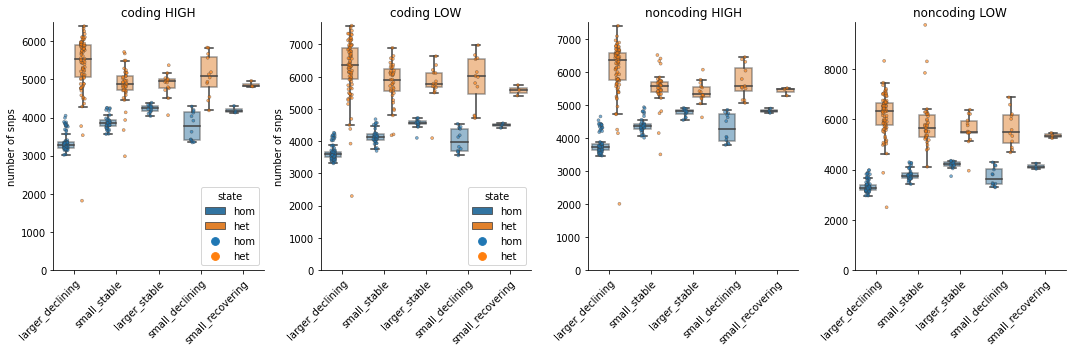

In [6]:
impacts = list(set(df_all['impact']))
locations = list(set(df_all['location']))
fig, axes = plt.subplots(1, 4, figsize = (15, 5))

for i in range(len(locations)):
    for j in range(len(impacts)):
        axi = axes[i*2+j]
        location = locations[i]
        impact = impacts[j]
        
        dfi = df_all[(df_all['location'] ==  location) & (df_all['impact'] ==  impact)]
        dfi = dfi[dfi['number'] != 0]
        dfi = dfi[dfi['group'] != 'exclude']

        sns.boxplot(ax=axi, data=dfi, x='group', y='number', hue='state', 
                    showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=dfi, x='group', y='number', hue='state', 
                      alpha=0.6, s=3, dodge=True, linewidth=0.5)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} {}'.format(location, impact))
        axi.set_xlabel('')
        axi.set_ylim(0, max(dfi['number']) + 100)
        if i == 0:
            axi.set_ylabel('number of snps')
        else:
            axi.set_ylabel('')
            axi.get_legend().set_visible(False)

# axes[2].set_ylim(0, 10000)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

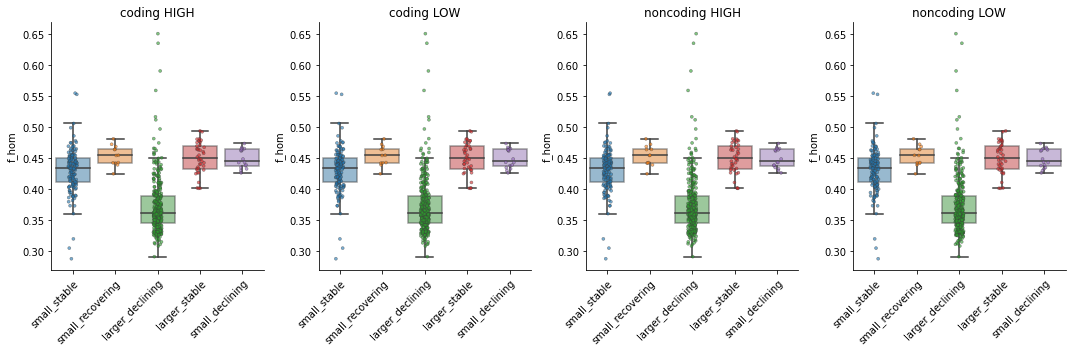

In [24]:
impacts = list(set(df_all['impact']))
locations = list(set(df_all['location']))
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(len(locations)):
    for j in range(len(impacts)):
        axi = axes[i * 2 + j]
        location = locations[i]
        impact = impacts[j]

        # Filter the data for this location and impact
        dfi = df_all[(df_all['location'] == location) & (df_all['impact'] == impact)]
        dfi = dfi[dfi['number'] != 0]
        dfi = dfi[dfi['group'] != 'exclude']

        # Calculate the ratio of hom to het
        ratio_data = df_all.pivot_table(index=['sample', 'variant', 'location', 'impact', 'rookery', 
                                       'year', 'group', 'MU', 'depth', 'exclude', 'batch'], 
                                columns='state', values='number', aggfunc='sum', fill_value=0)

        # Compute ratio and reset index for plotting
        ratio_data['f_hom'] = ratio_data['hom'] / (ratio_data['het'] + ratio_data['hom'])
        ratio_data = ratio_data.reset_index()
        
        sns.boxplot(ax=axi, data=ratio_data, x='group', y='f_hom', showfliers=False, boxprops=dict(alpha=0.5))
        sns.stripplot(ax=axi, data=ratio_data, x='group', y='f_hom', alpha=0.6, s=3, dodge=True, linewidth=0.5)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_title('{} {}'.format(location, impact))
        axi.set_xlabel('')
#         if i == 0:
#             axi.set_ylabel('Hom/Het Ratio')
#         else:
#             axi.set_ylabel('')
#             axi.get_legend().set_visible(False)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()
# plt.show()

In [25]:
ratio_data

state,sample,variant,location,impact,rookery,year,group,MU,depth,exclude,batch,het,hom,f_hom
0,dc_100028,snps,coding,HIGH,Mexico,2016.0,small_stable,Eastern Pacific,14.38,include,novo_UMass_Illumina_SR,4839,3960,0.450051
1,dc_100028,snps,coding,LOW,Mexico,2016.0,small_stable,Eastern Pacific,14.38,include,novo_UMass_Illumina_SR,5912,4240,0.417652
2,dc_100028,snps,noncoding,HIGH,Mexico,2016.0,small_stable,Eastern Pacific,14.38,include,novo_UMass_Illumina_SR,5635,4345,0.435371
3,dc_100028,snps,noncoding,LOW,Mexico,2016.0,small_stable,Eastern Pacific,14.38,include,novo_UMass_Illumina_SR,5517,3815,0.408808
4,dc_100029,snps,coding,HIGH,Mexico,2016.0,small_stable,Eastern Pacific,10.91,include,novo_UMass_Illumina_SR,4588,3979,0.464457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,dc_99951,snps,noncoding,LOW,Mexico,2017.0,small_stable,Eastern Pacific,8.33,include,novo_UMass_Illumina_SR,4112,3419,0.453990
532,dc_LeatherHatchDNA,snps,coding,HIGH,Florida,2017.0,small_declining,Northern Caribbean,13.30,include,Duffy_Illumina_SR,4940,4292,0.464905
533,dc_LeatherHatchDNA,snps,coding,LOW,Florida,2017.0,small_declining,Northern Caribbean,13.30,include,Duffy_Illumina_SR,5992,4445,0.425889
534,dc_LeatherHatchDNA,snps,noncoding,HIGH,Florida,2017.0,small_declining,Northern Caribbean,13.30,include,Duffy_Illumina_SR,5799,4710,0.448187
